In [1]:
import sys
sys.path.append("../")

from image_store import ImageStore
from matplotlib import pyplot as plt
from scipy.spatial import ConvexHull
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import json
import numpy as np

config = json.load(open("../config.json"))
store = ImageStore.read(config["STORE_DIR"])

In [2]:
def select(clusters, transformed):
    points, weights, indices, nans = [], [], [], []
    print("clusters.shape    ->", clusters.shape)
    print("transformed.shape ->", transformed.shape)
    for cluster in np.unique(clusters):
        cluster_points_index = np.where(clusters == cluster)[0]
        cluster_points = transformed[cluster_points_index]

        if cluster != -1 and cluster_points.shape[0] > 2:
            color = np.random.uniform(0.4, 0.9, size=(3,))
            hull = ConvexHull(cluster_points)
            hull_surface = hull.points[hull.vertices]
            hull_size = hull.vertices.shape[0]

            weights.append((np.arange(0, 1, 1/hull_size) + 
                            np.random.normal(0, 1/hull_size/5, hull_size))
                           [np.random.permutation(hull_size)])
            indices.append(cluster_points_index[hull.vertices])
            points.append(hull_surface)
        else:
            nans.append(cluster_points)
    return points, weights, indices, nans

In [16]:
tsne = TSNE(n_components=2, init="pca", random_state=100, method="exact")
pca = PCA(n_components=2)

dbscan = DBSCAN(eps=0.4, min_samples=5)
kmeans = KMeans(n_clusters=16, init="k-means++")

clusters = kmeans.fit_predict(store.encs)
transformed = tsne.fit_transform(store.encs)

points, weights, indices, nans = select(clusters, transformed)
print()
print("len(points)       ->", len(points))
print("len(weights)      ->", len(weights))
print("len(indices)      ->", len(indices))
print("len(nans)         ->", len(indices))

clusters.shape    -> (96,)
transformed.shape -> (96, 2)

len(points)       -> 13
len(weights)      -> 13
len(indices)      -> 13
len(nans)         -> 13


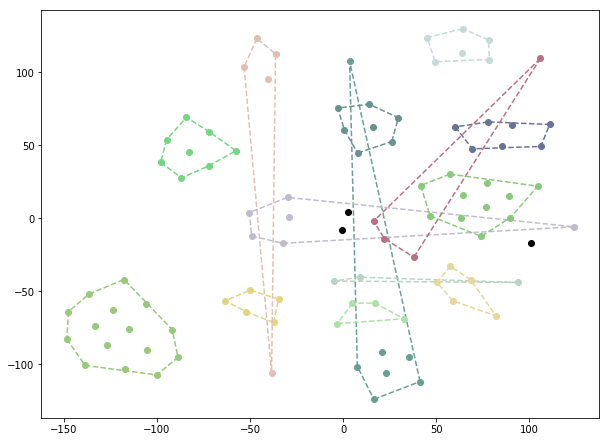

In [4]:
plt.figure(figsize=(10, 7.5))
counter = 0
for i, cluster in enumerate(np.unique(clusters)):
    cluster_points_index = np.where(clusters == cluster)[0]
    cluster_points = transformed[cluster_points_index]
    
    if cluster != -1 and cluster_points.shape[0] > 2:
        color = np.random.uniform(0.4, 0.9, size=(3,))
        hull_surface = points[counter]
        counter = counter + 1
        hull_size = hull_surface.shape[0]
        
        plt.plot(hull_surface[:, 0], hull_surface[:, 1], "--", c=color)
        plt.plot(hull_surface[(-1, 0), 0], hull_surface[(-1, 0), 1], "--", c=color)
        plt.plot(cluster_points[:, 0], cluster_points[:, 1], "o", c=color)
    else:
        plt.plot(cluster_points[:, 0], cluster_points[:, 1], "o", c=(0, 0, 0))

weights, indices, points = np.concatenate(weights), np.concatenate(indices), np.vstack(points)
order = weights.argsort()
indices, weights, points = indices[order], weights[order], points[order, :]

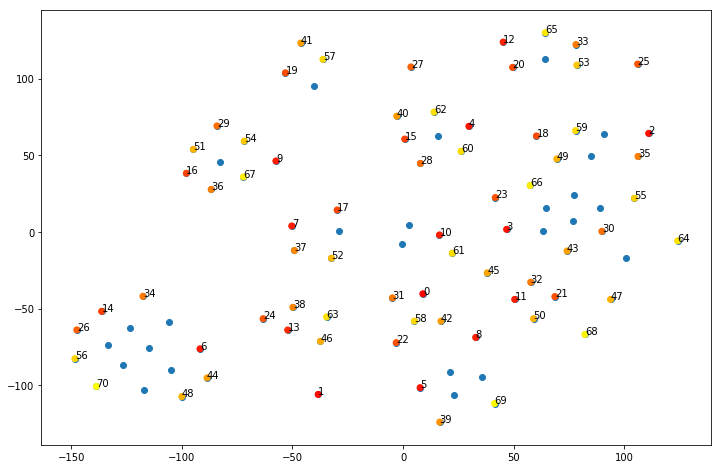

In [5]:
plt.figure(figsize=(12, 8))
plt.scatter(transformed[:, 0], transformed[:, 1])
plt.scatter(points[:, 0], points[:, 1], c=weights, cmap=plt.get_cmap("autumn"))
for i, txt in enumerate(np.argsort(weights)):
    plt.annotate(txt, (points[i, 0], points[i, 1]))
display()

In [6]:
indices.shape

(71,)

In [7]:
points.shape

(71, 2)

In [12]:
nans

[array([[106.15779 ,  49.248764],
        [110.991356,  64.320984]], dtype=float32),
 array([[100.830246, -16.762022]], dtype=float32),
 array([[ 93.76606 , -44.038486],
        [ 38.035217, -26.740704]], dtype=float32)]